In [29]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

from scatseisnet import ScatteringNetwork

%config InlineBackend.figure_format = "svg"

# parameter

Pour obtenir plus de coefficients, il suffit d'augmenter la résolution (qui détermine le nombre de wavelets par octave). Par exemple, pour la première couche, on obtient un total de 40 wavelets. Les divisions d'octave sont appliquées sur la bande de fréquence commençant à 5 Hz. Voici un exemple de paramètres pour les banques de filtres :

```python
bank_keyword_arguments = (
    {"octaves": 4, "resolution": 10, "quality": 1},
    {"octaves": 5, "resolution": 5 , "quality": 3},
)


## TDMS Reader demo.
## File: laach_UTC_20210701_081801.178.tdms
## Number of channels in file: 640
## Time samples in file: 100000
## Sampling frequency (Hz): 5000.0
## Size of data loaded: (100001, 441)

441 Trace(s) in Stream:

XX.120.00.ZZZ | 2021-07-01T08:18:02.000000Z - 2021-07-01T08:18:22.000000Z | 5000.0 Hz, 100001 samples
...
(439 other traces)
...
XX.560.00.ZZZ | 2021-07-01T08:54:42.000000Z - 2021-07-01T08:55:02.000000Z | 5000.0 Hz, 100001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

## Load scattering coefficients

In [31]:
# Chargement des données depuis le fichier fourni
with np.load("scattering_coefficients.npz", allow_pickle=True) as data:
    order_1_loaded = data["order_1"]
    order_2_loaded = data["order_2"]
    times_loaded = data["times"]

order_1_loaded.shape, order_2_loaded.shape, times_loaded.shape


((441, 60), (441, 60, 35), (441,))

## Extract independant features

In [32]:
import pickle
import matplotlib.dates as mdates

from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA,PCA

plt.rcParams["date.converter"] = "concise"
%config InlineBackend.figure_format = "svg"

# Load data from file
with np.load("scattering_coefficients.npz", allow_pickle=True) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 441 samples of 2160 dimensions each.


In [33]:
model = FastICA(n_components=6, whiten="unit-variance", random_state=42)
ica_features = model.fit_transform(scattering_coefficients)

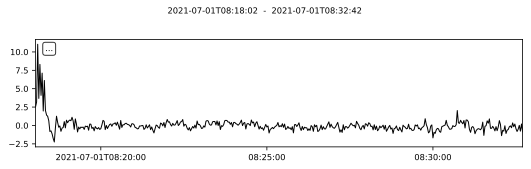

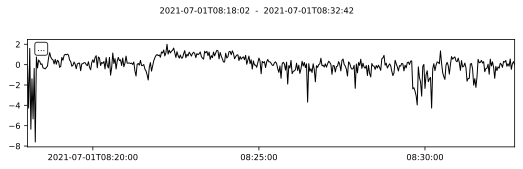

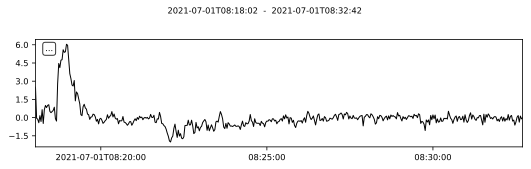

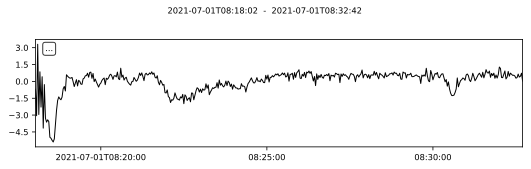

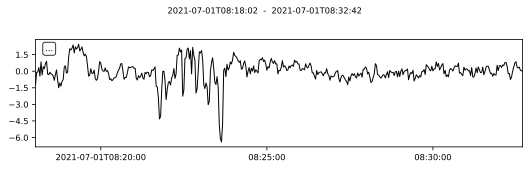

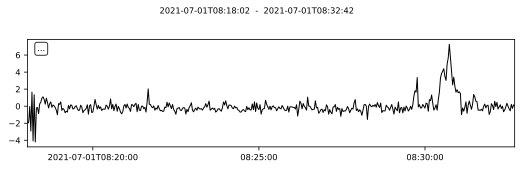

In [34]:
# Définir le temps de début et l'intervalle d'échantillonnage pour ObsPy
start_time = UTCDateTime(times[0])
sampling_interval = 2

# Création des streams ObsPy pour les composantes ICA
streams = []
for i in range(6):
    trace = Trace(data=ica_features[:, i])
    trace.stats.starttime = start_time
    trace.stats.delta = sampling_interval
    stream = Stream(traces=[trace])
    streams.append(stream)

    # Visualisation de chaque stream
    streams[i].plot()

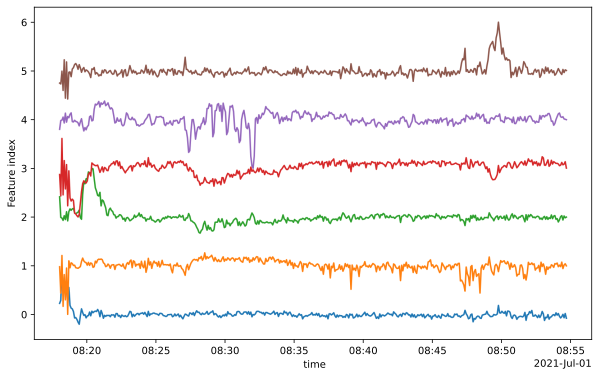

In [10]:
# Normalize the transformed features for display
features_test_normalized = ica_features / np.abs(ica_features).max(axis=0)

# Figure instance
fig = plt.figure(figsize=(10, 6), dpi=200)
ax = plt.axes()

# Plot features
ax.plot(times, features_test_normalized + np.arange(ica_features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel(" time")

# Show
plt.show()


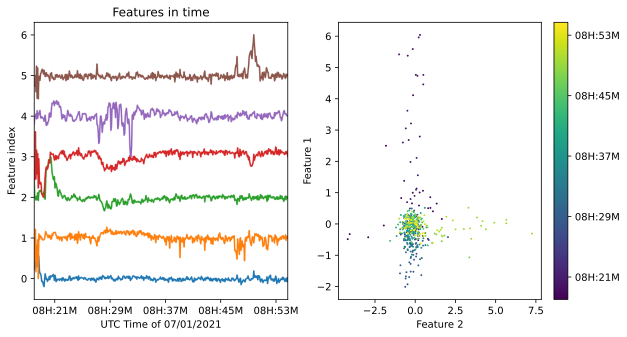

In [26]:
# Normalize features for display
features_normalized = ica_features / np.abs(ica_features).max(axis=0)
myFmt = mdates.DateFormatter('%HH:%MM')

# Figure and axes instance
fig, axes = plt.subplots(1,2,figsize=(10,5),dpi=200)

# Plot features in time
axes[0].plot(times, features_normalized + np.arange(ica_features.shape[1]), rasterized=True)
axes[0].set_xlim(times.min(),times.max())
axes[0].xaxis.set_major_formatter(myFmt)
axes[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=8)) 
axes[0].set_ylabel("Feature index")
axes[0].set_xlabel("UTC Time of 07/01/2021")
axes[0].set_title("Features in time")


# Plot the first two principal components
mappable = axes[1].scatter(ica_features[:,5],ica_features[:,2],s=1,c=mdates.date2num(times))
axes[1].set_ylabel("Feature 1")
axes[1].set_xlabel("Feature 2")

cbar_ax = plt.colorbar(mappable)
cbar_ax.ax.set_ylim(times.min(),times.max())
cbar_ax.ax.yaxis.set_major_formatter(myFmt)
cbar_ax.ax.yaxis.set_major_locator(mdates.MinuteLocator(interval=8)) 

# Show
plt.show()

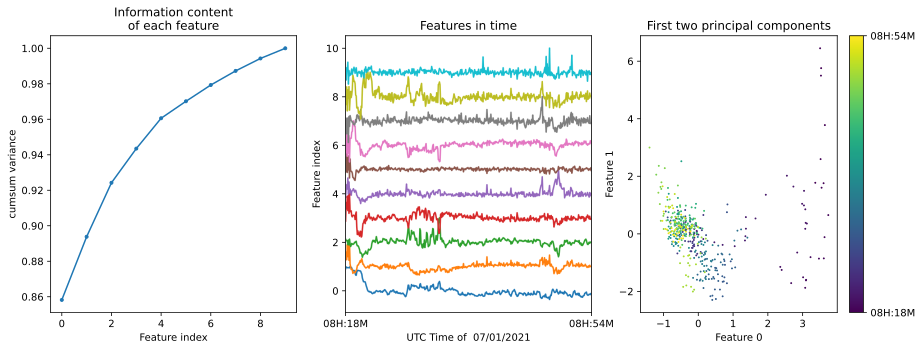

In [38]:
pca_model = PCA(n_components=10, whiten=True)
pca_features = pca_model.fit_transform(scattering_coefficients)# Normalize features for display
features_normalized = pca_features / np.abs(pca_features).max(axis=0)
myFmt = mdates.DateFormatter('%HH:%MM')

# Figure and axes instance
fig, axes = plt.subplots(1,3,figsize=(15,5),dpi=200)

# Plot the cumulative sum of the explained variance ratio of the principal components
axes[0].plot(np.cumsum(pca_model.explained_variance_ratio_/sum(pca_model.explained_variance_ratio_)),'.-')
axes[0].set_ylabel("cumsum variance")
axes[0].set_xlabel("Feature index")
axes[0].set_title("Information content\nof each feature")

# Plot features in time
axes[1].plot(times, features_normalized + np.arange(features_normalized.shape[1]), rasterized=True)
axes[1].set_xlim(times.min(),times.max())
axes[1].xaxis.set_major_formatter(myFmt)
axes[1].xaxis.set_major_locator(mdates.HourLocator(interval=6))
axes[1].set_ylabel("Feature index")
axes[1].set_xlabel("UTC Time of  07/01/2021")
axes[1].set_title("Features in time")



# Plot the first two principal components
mappable = axes[2].scatter(pca_features[:,0],pca_features[:,1],s=1,c=mdates.date2num(times))
axes[2].set_ylabel("Feature 1")
axes[2].set_xlabel("Feature 0")
axes[2].set_title("First two principal components")

cbar_ax = plt.colorbar(mappable)
cbar_ax.ax.set_ylim(times.min(),times.max())
cbar_ax.ax.yaxis.set_major_formatter(myFmt)
cbar_ax.ax.yaxis.set_major_locator(mdates.HourLocator(interval=6))

# Show
plt.show()

In [39]:
# Load the test data from the provided file
with np.load("scattering_coefficientsTest.npz", allow_pickle=True) as data:
    order_1_test = data["order_1"]
    order_2_test = data["order_2"]
    times = data["times"]

# Reshape and stack scattering coefficients of all orders for the test data
order_1_test = order_1_test.reshape(order_1_test.shape[0], -1)
order_2_test = order_2_test.reshape(order_2_test.shape[0], -1)
scattering_coefficients_test = np.hstack((order_1_test, order_2_test))

# Transform into log for the test data
scattering_coefficients_test = np.log(scattering_coefficients_test)

# Use the previously trained FastICA model to transform the test data
features_test = model.transform(scattering_coefficients_test)





In [45]:
# print info about shape
n_times, n_coeff = scattering_coefficients_test.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 441 samples of 2160 dimensions each.


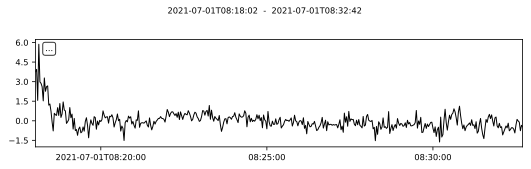

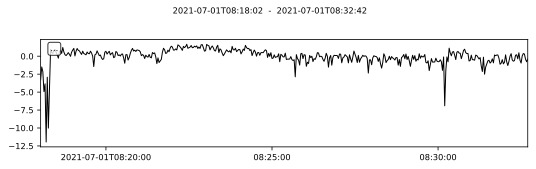

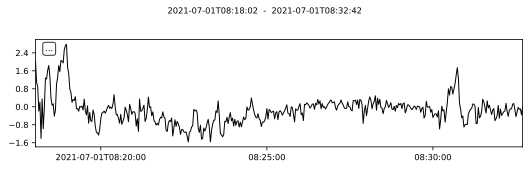

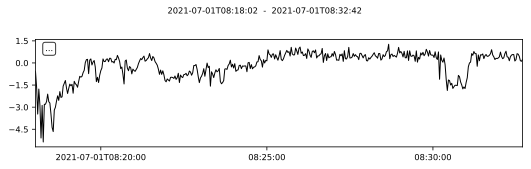

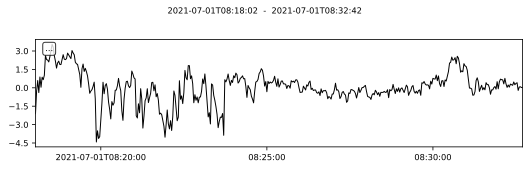

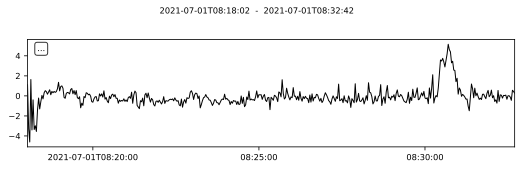

In [40]:
# Définir le temps de début et l'intervalle d'échantillonnage pour ObsPy
start_time = UTCDateTime(times[0])
sampling_interval = 2

# Création des streams ObsPy pour les composantes ICA
streams = []
for i in range(6):
    trace = Trace(data=features_test[:, i])
    trace.stats.starttime = start_time
    trace.stats.delta = sampling_interval
    stream = Stream(traces=[trace])
    streams.append(stream)

    # Visualisation de chaque stream
    streams[i].plot()

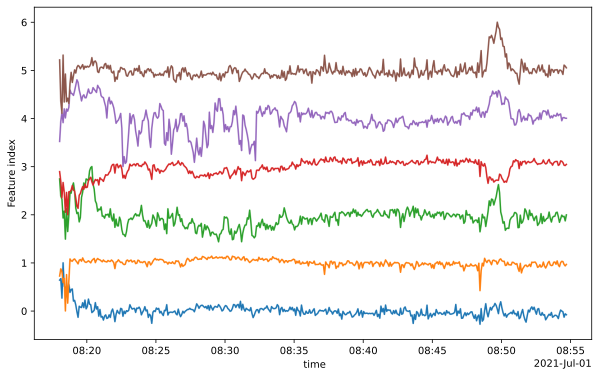

In [41]:
# Normalize the transformed features for display
features_test_normalized = features_test / np.abs(features_test).max(axis=0)

# Figure instance
fig = plt.figure(figsize=(10, 6), dpi=200)
ax = plt.axes()

# Plot features
ax.plot(times, features_test_normalized + np.arange(features_test.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel(" time")

# Show
plt.show()


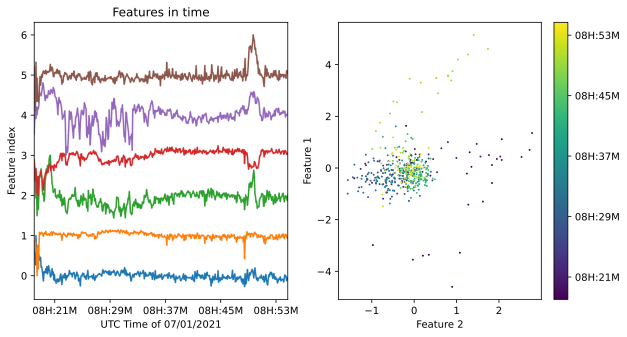

In [42]:
# Normalize features for display
features_normalized = features_test / np.abs(features_test).max(axis=0)
myFmt = mdates.DateFormatter('%HH:%MM')

# Figure and axes instance
fig, axes = plt.subplots(1,2,figsize=(10,5),dpi=200)

# Plot features in time
axes[0].plot(times, features_normalized + np.arange(features_test.shape[1]), rasterized=True)
axes[0].set_xlim(times.min(),times.max())
axes[0].xaxis.set_major_formatter(myFmt)
axes[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=8)) 
axes[0].set_ylabel("Feature index")
axes[0].set_xlabel("UTC Time of 07/01/2021")
axes[0].set_title("Features in time")


# Plot the first two principal components
mappable = axes[1].scatter(features_test[:,2],features_test[:,5],s=1,c=mdates.date2num(times))
axes[1].set_ylabel("Feature 1")
axes[1].set_xlabel("Feature 2")

cbar_ax = plt.colorbar(mappable)
cbar_ax.ax.set_ylim(times.min(),times.max())
cbar_ax.ax.yaxis.set_major_formatter(myFmt)
cbar_ax.ax.yaxis.set_major_locator(mdates.MinuteLocator(interval=8)) 

# Show
plt.show()

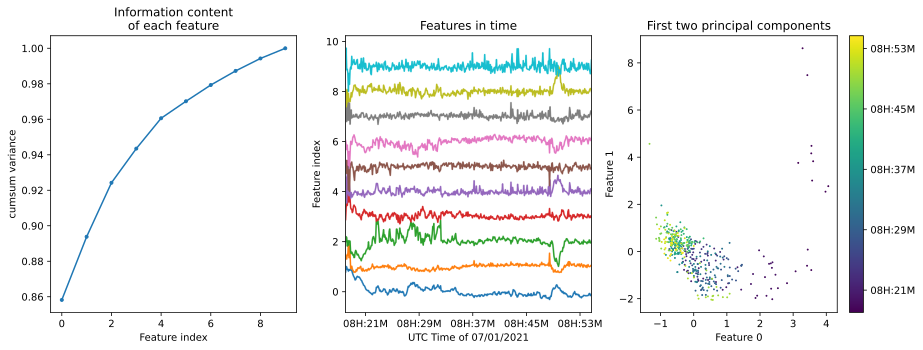

In [43]:

pca_features = pca_model.transform(scattering_coefficients_test)# Normalize features for display
features_normalized = pca_features / np.abs(pca_features).max(axis=0)
myFmt = mdates.DateFormatter('%HH:%MM')

# Figure and axes instance
fig, axes = plt.subplots(1,3,figsize=(15,5),dpi=200)

# Plot the cumulative sum of the explained variance ratio of the principal components
axes[0].plot(np.cumsum(pca_model.explained_variance_ratio_/sum(pca_model.explained_variance_ratio_)),'.-')
axes[0].set_ylabel("cumsum variance")
axes[0].set_xlabel("Feature index")
axes[0].set_title("Information content\nof each feature")

# Plot features in time
axes[1].plot(times, features_normalized + np.arange(features_normalized.shape[1]), rasterized=True)
axes[1].set_xlim(times.min(),times.max())
axes[1].xaxis.set_major_formatter(myFmt)
axes[1].xaxis.set_major_locator(mdates.MinuteLocator(interval=8)) 
axes[1].set_ylabel("Feature index")
axes[1].set_xlabel("UTC Time of 07/01/2021")
axes[1].set_title("Features in time")



# Plot the first two principal components
mappable = axes[2].scatter(pca_features[:,0],pca_features[:,1],s=1,c=mdates.date2num(times))
axes[2].set_ylabel("Feature 1")
axes[2].set_xlabel("Feature 0")
axes[2].set_title("First two principal components")

cbar_ax = plt.colorbar(mappable)
cbar_ax.ax.set_ylim(times.min(),times.max())
cbar_ax.ax.yaxis.set_major_formatter(myFmt)
cbar_ax.ax.yaxis.set_major_locator(mdates.MinuteLocator(interval=8)) 

# Show
plt.show()

In [ ]:
# Load the scattering network
network = pickle.load(open("network/scattering_network.pickle", "rb"))

# Load the dimensionality reduction model
dimension_model = pickle.load(open("dimension_model.pickle", "rb"))

# Load data from file
with np.load("independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

In [ ]:
# Pick a feature
feature_id = 8
feature = features[:, feature_id]

# Figure creation
fig = plt.figure()
ax = plt.axes()

# Plot the weights
ax.plot(times, feature)
ax.set_ylabel(f"Amplitude of feature {feature_id}")

# Show
plt.show()

In [ ]:
weights = dimension_model.components_[feature_id]
print(len(weights))


In [11]:
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
n_order_1

24

Ce code analyse comment différentes fréquences (ou autres caractéristiques extraites par le réseau de scattering) contribuent à une caractéristique particulière du modèle de réduction de dimensionnalité. Cela peut donner des insights sur la nature de la caractéristique en termes de fréquences ou d'autres mesures dans les données originales.

## clustering

l'algorithme KMeans pour effectuer un clustering sur un ensemble de données représenté par la variable features

In [49]:
N_CLUSTERS = 4
from sklearn.cluster import KMeans

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, n_init="auto", random_state=4)
model.fit(scattering_coefficients)

# Predict cluster for each sample (Entraînement du Modèle)
predictions = model.predict(scattering_coefficients)

C:\Users\cedri\anaconda3\envs\obspy\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


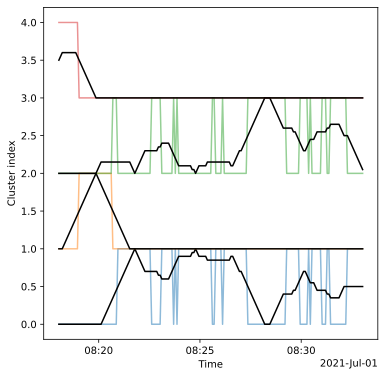

In [50]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")

plt.show()


La heatmap que vous avez partagée illustre les centroïdes pour chaque cluster identifié par l'algorithme KMeans.
Chaque ligne de la heatmap correspond à une caractéristique (feature index), et chaque colonne à un cluster spécifique (cluster index).
Les couleurs indiquent l'amplitude ou l'intensité de chaque caractéristique au sein de chaque cluster.

In [ ]:
centroids = np.abs(model.cluster_centers_)

# Plot the centroids
fig = plt.figure()
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="RdPu")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Ticks below
ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(centroids.shape[1]))
ax.invert_yaxis()

# Show
plt.show()

In [ ]:
N_WAVEFORMS = 5
import obspy

# Read the stream
#sed").select(chtream = obspy.read("scattering_stream.mseannel="ZZZ")
waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    closest = times[predictions == cluster][distance.argsort()[:5]]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = obspy.UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy()
        traces.append(trace)
    waveforms.append(traces)

In [ ]:
print("Shape of times:", times.shape)
print("Shape of predictions:", predictions.shape)
print("Shape of features:", features.shape)

In [ ]:
# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=300)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show()